In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utils

In [74]:
def keep_cleaning(on, off, threshold=2.0, verbose=False):
    """Compute residuals from data after clean component subtraction. 
    The rms and baseline is determined from the "offpulse" time series, 
    and the signal strength is calculated from the "onpulse" region.
    """
    rms = np.std(off)
    median = np.median(off) # median is more reliable than mean

    datamax = np.max(on)

    limit = median + threshold * rms

    if datamax > limit:
        if verbose:
            print("Onpulse data maximum still above threshold")
            print("{0:g} > {1:g}".format(datamax, limit))
        return True
    else:
        if verbose:
            print("No more data are above the given threshold")
        return False

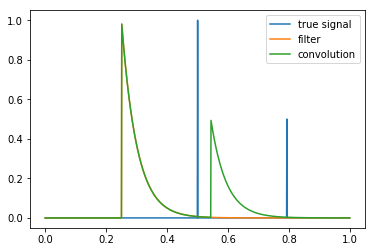

peak intensity=0.957077560454
rms=0.0510469444607
snr=18.748968632
on-pulse range=200:700
Found clean component outside nominal on-pulse window
   comp. idx=37
Stopping here


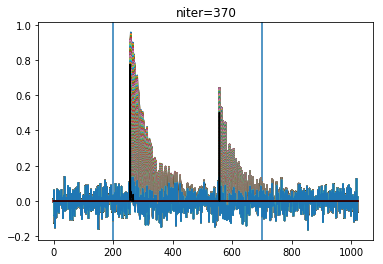

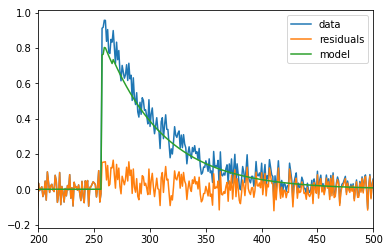

In [111]:
## Test deconvolution process
np.random.seed(11111)
x = np.linspace(0, 1, 1024)
x0 = x[x.size/4]

f = np.zeros_like(x)
f[f.size/2] = 1.0
f[f.size/2+300] = 0.5

response = np.zeros_like(f)
response[response.size/2] = 1.0 # i.e. assume response is a delta function

tau = 0.05
h = np.exp(-(x-x0)/tau)
h[x <= x0] = 0

g = np.convolve(f, h, mode="full")
g = np.roll(g[g.size/4:3*g.size/4], -1)

plt.plot(x, f, label="true signal")
plt.plot(x, h, label="filter")
plt.plot(x, g, label="convolution")
plt.legend()
plt.show()

# Initialise counters and boolean checks
loop = True
niter = 0

# Create an empty array of shape and type of data to store clean components
data = np.copy(g) + np.random.normal(0, 0.05, g.size)
data_init = np.copy(data)
clean_components = np.zeros_like(data)
gain = 0.01
filter_guess = np.exp(-(x-x0)/0.056)


plt.plot(data)
on_lims = (200, 700)
plt.axvline(on_lims[0])
plt.axvline(on_lims[1])

offpulse = np.concatenate((data[:on_lims[0]], data[on_lims[1]:]))
onpulse = data[on_lims[0]:on_lims[1]]

init_rms = np.std(offpulse)

print "peak intensity={0}".format(onpulse.max())
print "rms={0}".format(init_rms)
print "snr={0}".format(onpulse.max()/init_rms)
thresh = 2.5
print "on-pulse range={0}:{1}".format(on_lims[0], on_lims[1])

while loop and niter < 1000:
    
    imax = np.argmax(data)
    dmax = np.max(data)

    if imax < on_lims[0]  or imax > on_lims[1]:
        print("Found clean component outside nominal on-pulse window")
        print("   comp. idx={0}".format(imax))
        print("Stopping here")
        break
    
    niter += 1
    
    temp_clean_comp = np.zeros_like(clean_components)
    temp_clean_comp[imax] = dmax * gain
    clean_components[imax] += dmax * gain
    
    rest_func = np.convolve(temp_clean_comp, response, mode="same")
    rest_func = np.convolve(rest_func, filter_guess, mode="same")
    
    component = (rest_func / rest_func.max()) * dmax * gain
    component = np.roll(component, np.abs(np.argmax(rest_func)-np.argmax(temp_clean_comp)))
    
    cleaned = data - component
    
    onpulse = cleaned[on_lims[0]:on_lims[1]]
    
    loop = keep_cleaning(onpulse, offpulse, threshold=thresh, verbose=False)
    
    plt.plot(cleaned)
    plt.plot(component, color="r")
    data = np.copy(cleaned)
    
plt.plot(clean_components, color="k")
plt.title("niter={0}".format(niter))
plt.show()
    
model = np.convolve(clean_components, h, mode="same")
model = np.roll(model, -np.argmax(model)+np.argmax(data_init))
    

plt.plot(data_init, label="data")
plt.plot(data_init - model, label="residuals")
plt.plot(model, label="model")
plt.xlim(200,500)
plt.legend()
plt.show()

In [112]:
def clean(data, nbins, tau, x0, opwindow,
          pbf="thin", gain=0.05, maxiter=1000, limit=2.0, impulse_resp=None,
          verbose=False, showplots=False):

    # Initialise counters and boolean checks
    loop = True
    niter = 0

    # Create an empty array of shape and type of data to store clean components
    clean_components = np.zeros_like(data)

    # Compute on-pulse and off-pulse data regions
    # TODO: make these masked arrays?
    onpulse = np.zeros_like(data)
    onpulse_min = opwindow[0]
    onpulse_max = opwindow[1]
    onpulse[onpulse_min:onpulse_max] = data[onpulse_min:onpulse_max]
    offpulse = np.concatenate((data[:onpulse_min], data[onpulse_max:]))
    

    # Set up plotting so that we just re-draw on the same canvas
    if showplots:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        plt.axvline(onpulse_min)
        plt.axvline(onpulse_max)
        ldata, = ax.plot(data, label="data")
        ldatasub, = ax.plot(data, label="subtracted")
        lccomps, = ax.plot(clean_components, label="clean comps")
        lsubcomp, = ax.plot(clean_components, label="subtracted comp")


    orig_data = np.copy(data) # Copy the original data so we can see how the process 
                              # is progressing compared to the original time series data
   
    # Create the PBF which we are testing
    g = utils.generate_pbf(tau, nbins, x0, pbf=pbf, size=nbins)
    g /= g.max()
    
    # This is the main CLEAN loop
    while loop and niter < maxiter:

        # Find maximum component in data
        imax = np.argmax(data)
        dmax = data[imax]

        if not (onpulse_min < imax < onpulse_max):
            # We only want to deconvolve within the pulse window
            print("Found peak outside CLEAN window, stopping here. "
                  "Iteration {0}, peak @ bin {1}".format(niter, imax))
            break

        # Keep count of number of loops
        niter += 1

        # Create a clean component
        temp_clean_comp = np.zeros_like(clean_components)
        temp_clean_comp[imax] = dmax * gain
        clean_components[imax] += dmax * gain

        # Update the plot for every 10 iterations
        if (niter % 10) == 0 and showplots:
            ldata.set_ydata(orig_data)
            lccomps.set_ydata(clean_components)
            plt.title("Iteration {0}".format(niter))

        # Subtract the clean component convolved with the restoring function
        # TODO: what do we need to subtract here? dmax * gain * something of the same shape as data
        #restoring = default_restfunc(nbins, 150.0, 0.01, 1.0, 10.0)
        if impulse_resp is None:
            # TODO: this needs to be estimated more intelligently... currently just a random guess
            impulse_resp = np.zeros_like(clean_components)
            impulse_resp[1:10] = 1.0 

        # Create the restoring function from the instrumental and PBF responses
        # In this case, we want to convolved all of the clean components and subtract
        # that from the ORIGINAL data, and copy that subtracted version to then check 
        # residuals, etc.
        restoring = np.convolve(temp_clean_comp, impulse_resp, mode="same")
        restoring = np.convolve(g, restoring, mode="same")
        
        # shift the restoring function to be centred on the clean component
        restoring = np.roll(restoring, -np.abs(np.argmax(restoring)-np.argmax(temp_clean_comp)))
        subcomp = dmax * gain * (restoring / restoring.max())
        subcomp[:onpulse_min] = 0.0
        subcomp[onpulse_max:] = 0.0

        data = data - subcomp

        if (niter % 10) == 0 and showplots:
            lsubcomp.set_ydata(subcomp)
            ldatasub.set_ydata(data)
            #plt.draw()
            #plt.pause(0.05)
            plt.legend()
            #plt.show()
            fig.canvas.draw()
            plt.show()

        # Check subtracted data to determine if we should continue removing components
        onpulse[onpulse_min:onpulse_max] = data[onpulse_min:onpulse_max]
        loop, dmax = check_residuals(onpulse, offpulse, threshold=limit, verbose=verbose)

        if verbose:
            print("Iteration {0}: max residual = {1}".format(niter, dmax))

        if verbose and loop is False:
            print("Exited CLEAN loop on iteration {0}".format(niter))

        if verbose and niter == maxiter:
            print("Reached maximum iterations within CLEAN loop. Exiting.")


    print("Convolving CLEAN components...")
    # Convolve clean component with the response function
    # TODO: response function is just a unit rectangle, but we need to include DM/instrumental/binning effects
    #resp = utils.generate_pbf(tau, nbins, x0, pbf=pbf, size=nbins)
    
    # compute the clean model from the components and response function
    clean_model = np.convolve(clean_components, impulse_resp, mode="same")
    clean_model /= clean_model.max()
    
    plt.plot(orig_data, label="original")
    plt.plot(data, label="residuals")
    plt.plot(subcomp, label="last subcomp")
    plt.legend()
    plt.show()

    # restore the convolved clean components
    cleaned_data = clean_model
    
    # and return the residuals
    residuals = data

    return clean_components, clean_model, cleaned_data, residuals,  g

In [ ]:
t, pulse, intrinsic, tau, off = utils.simulate_pulse(1024, tau=30)
w = [450, 720]
plt.figure()
plt.plot(t, pulse, label="scattered pulse")
plt.plot(t, intrinsic, label="intrinsic pulse")
plt.axvline(w[0])
plt.axvline(w[1])
plt.legend()
plt.show()

In [ ]:
plt.figure()
ccomps, cmodel, cdata, res, pbfmodel = clean(pulse, 1024, tau, off, w, 
                                             pbf="thin", gain=0.05, maxiter=100, limit=5.0,
                                             impulse_resp=intrinsic, verbose=False, showplots=False)
plt.show()

In [ ]:
plt.figure()
plt.plot(cmodel, label="model")
plt.plot(pbfmodel, label="PBF")
plt.plot(cdata, label="restored")
plt.plot(res, label="residuals")
plt.plot(intrinsic, label="actual")
plt.axvline(w[0])
plt.axvline(w[1])
plt.xlim(400, 850)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(cmodel+res, label="reconstructed pulse")
plt.plot(np.roll(pbfmodel, -np.argmax(pbfmodel)+1), label="pbf")
plt.legend()
plt.show()

In [ ]:
plt.plot(ccomps)
plt.plot(cmodel+res)
plt.ylim(0,0.2)
plt.xlim(400,600)
plt.show()